In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy
import os
from src.normalization import word_normalization, letter_normalization
from src import page, words, characters
from src.helpers import implt, resize
from src.tfhelpers import Model
from src.datahelpers import idx2char

/Users/akshaygoyal/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akshaygoyal/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akshaygoyal/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/akshaygoyal/Library/Python/3.7/lib/pyth

Loading segmentation models...
INFO:tensorflow:Restoring parameters from /Users/akshaygoyal/Desktop/Projects/CBSE_Project/OCR/handwriting-ocr-master/new/src/../../models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from /Users/akshaygoyal/Desktop/Projects/CBSE_Project/OCR/handwriting-ocr-master/new/src/../../models/gap-clas/RNN/Bi-RNN-new


In [2]:
def OCR(folderpath):
    plt.rcParams['figure.figsize'] = (15.0, 10.0)
    LANG = 'en'
    MODEL_LOC_CHARS = 'src/CharClassifier'
    CHARACTER_MODEL = Model(MODEL_LOC_CHARS)

    def load_images_from_folder(folder):
        images = []
        for filename in os.listdir(folder):
            images.append(filename)
        return images
    files = load_images_from_folder(folderpath)

    for i in files:
        IMG = folderpath+'/'+i   
        print(IMG)
        image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
        # implt(image)
        # Crop image and get bounding boxes
        crop = page.detection(image)
        # implt(crop)
        boxes = words.detection(crop)
        lines = words.sort_words(boxes)
        def recognise(img):
            """Recognition using character model"""
            # Pre-processing the word
            img = word_normalization(
                img,
                60,
                border=False,
                tilt=True,
                hyst_norm=True)

            # Separate letters
            img = cv2.copyMakeBorder(
                img,
                0, 0, 30, 30,
                cv2.BORDER_CONSTANT,
                value=[0, 0, 0])
            gaps = characters.segment(img, RNN=True)

            chars = []
            for i in range(len(gaps)-1):
                char = img[:, gaps[i]:gaps[i+1]]
                char, dim = letter_normalization(char, is_thresh=True, dim=True)
                # TODO Test different values
                if dim[0] > 4 and dim[1] > 4:
                    chars.append(char.flatten())

            chars = np.array(chars)
            word = ''        
            if len(chars) != 0:
                pred = CHARACTER_MODEL.run(chars)                
                for c in pred:
                    word += idx2char(c)

            return word

        st = ''
        for line in lines:
            a = " ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line])
            st = st+a

        numpy.savetxt('txt/file'+str(files.index(i))+'.txt', [st], fmt='%s')


# Please replace folderpath with path of folder containing images

INFO:tensorflow:Restoring parameters from src/CharClassifier
data/text3.jpg


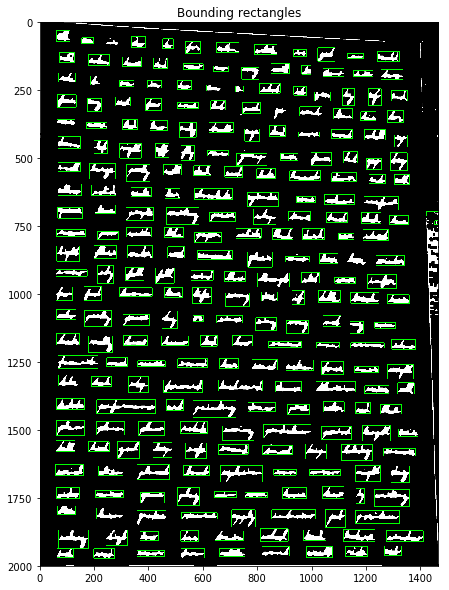

In [ ]:
OCR('data')